## 0. Imports Preliminaries

In [1]:
!pip install nltk py-readability-metrics spacy keras==2.8

In [2]:
#0. Preliminaries
import pandas as pd
import nltk
nltk.download('punkt')
from readability import Readability

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import numpy as np
from sklearn.model_selection import train_test_split
import re
import spacy

In [4]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lluneta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from transformers import pipeline
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student", max_length = 512, truncation = True)

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    tokenizer = tokenizer,
    return_all_scores=True
)

2023-12-09 19:04:44.711649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 19:04:44.853290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-09 19:04:44.853315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-09 19:04:44.889098: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 19:04:45.480592: W tensorflow/stream_executor/platform/de

## 1. Load Data

In [3]:
#1. Import Data
df = pd.read_csv("../data/chunked_author_data.csv")

In [45]:
def select_equal_groups(group: pd.core.groupby.generic.DataFrameGroupBy, n: int):

    return group.sample(min(n, len(group)), random_state=42)

share_train = 0.8
share_test = 0.3
samples_train = int(len(df)*(share_train*(1-share_test)))
samples_per_group = int(samples_train/5)

df['ID'] = range(0, len(df))
df_abstract_intro = df[~df['Type'].str.contains("conclusion_chunked")]
df_train= df_abstract_intro.groupby("Author", group_keys=False)\
        .apply(select_equal_groups, samples_per_group)\
        .reset_index(drop=True)

df_test_val = df[~df['ID'].isin(df_train['ID'])]
df_val = df_test_val[~df_test_val['Type'].str.contains("conclusion_chunked")]
df_val, df_test_0  = train_test_split(df_val, train_size = 0.5, stratify = df_val['Author'], random_state = 42)
df_test_1 = df_test_val[df_test_val['Type'].str.contains("conclusion_chunked")]
#df_test, df_val  = train_test_split(df_test_val, train_size = 0.5, stratify = df_test_val['Author'], random_state = 42)

In [46]:
df_train['Author'].value_counts()

Author
Aman Madaan     37
Hugo Touvron    37
Timo Schick     37
Zhiqing Sun     37
GPT-3.5         32
Name: count, dtype: int64

In [48]:
df_val['Author'].value_counts()

Author
Aman Madaan     10
Zhiqing Sun     10
Hugo Touvron     8
Timo Schick      7
Name: count, dtype: int64

In [25]:
df_val['Author'].value_counts()

Author
Aman Madaan     16
Timo Schick     15
Zhiqing Sun     15
Hugo Touvron    12
GPT-3.5          3
Name: count, dtype: int64

In [7]:
for c in df['Chunk']:
    if 'waning' in c:
        print(c)

 The waning of Mooreâs Law has shifted the focus of the tech industry towards alternative methods for continued performance gains. While optimizing compilers are a standard tool to help increase program efficiency, programmers continue to shoulder much responsibility in crafting and refactoring code with better performance characteristics. In this paper, we investigate the ability of large language models (LLMs) to suggest functionally correct, performance improving code edits. We hypothesize that language models can suggest such edits in ways that would be impractical for static analysis alone. We investigate these questions by curating a large-scale dataset of Performance-Improving Edits, PIE. PIE contains trajectories of programs, where a programmer begins with an initial, slower version and iteratively makes changes to improve the programâs performance. We use PIE to evaluate and improve the capacity of large language models. Specifically, we use examples from PIE to fine-tune 

In [8]:
#df_train_val, df_test = train_test_split(df, train_size = 0.8, random_state = 42)
#df_train, df_val = train_test_split(df_train_val, train_size = 0.8, random_state = 42)

## 2. Clean Data 

In [9]:
def regex(string: str):
    """
    Function that applies regular expressions to a string based on the specified model.
    :param string: The input string.
    :param model: The model to determine which regular expressions to apply.
    :return: The modified string.
    """
    string = re.sub(r'e\.g\.', 'eg', string)  # replace e.g. with eg
    string = re.sub(r'i\.e\.', 'ie', string)  # replace i.e. with ie
    string = re.sub(r'-', ' ', string)  # replace - with space
    string = re.sub(r'[0-9]', '0', string)  # each digit will be represented as a 0
    string = re.sub(r'\(.*?\)', '', string) # remove parentheses and the text within
    string = re.sub(r'\[.*?\]', '', string) # remove brackets and the text within
    string = re.sub(r"https?:\/\/[a-zA-Z0-9.\/]+", "@", string) # remove links
    string = re.sub('[^A-Za-z0-9\s\.,\?!:;]+', '', string)# Remove special characters, so math formulas simplified.
    string = re.sub(r'\s\s+', ' ', string) # remove if there is more than 1 space, inlcuding new line \n and tab \t
    return string.strip() # Remove extra spaces at the begningining and end.

assert regex("a\t\n b") == "a b"
assert regex("q123") == "q000"
assert regex("a (something something) b (sth th)") == "a b"
assert regex("a [something something] b [sth12 th]") == "a b"
assert regex("2 + 5 % 2") == "0 0 0"
assert regex(",!;:.?") == ",!;:.?"

## 3. Add Features

In [10]:
#Flesch 
def flesch_readability_scale(text):
    try:
        r = Readability(text)
        f = r.flesch()
        score_out = f.score
    #not possible if less than 100 words
    except:
        score_out = np.nan
    return score_out

In [ ]:
df['flesch_score'] = df['Chunk'].apply(flesch_readability_scale)
average_score_author = df['flesch_score', 'Author'].dropna().groupby('Author').mean().reset_index()
average_score_author.columns = ["Author", "mean_flesch"]
df = df.join(average_score_author)
df.loc[df['flesch_score'].isnull(), 'flesch_score'] = df[df['flesch_score'].isnull(), 'mean_flesch']

In [10]:
# Sentiment Analysis (Positive Score)
tokenizer_kwargs = {'truncation':True,'max_length':512}
def sentiment_analysis_score(text):
    results_senti = distilled_student_sentiment_classifier(text, **tokenizer_kwargs)
    positive_score = [x['score'] for x in results_senti[0] if x['label'] == 'positive']
    score_out = positive_score[0] if len(positive_score) == 1 else np.nan
    return score_out                          

In [12]:
def lexical_diversity(text):
    words = nltk.word_tokenize(text)
    return len(set(words)) / len(words)

assert lexical_diversity('a a b') == 2/3

In [13]:
from nltk.tokenize import sent_tokenize, word_tokenize

def avg_word_per_sentence(text):
    return np.mean([len(word_tokenize(sentence)) for sentence in sent_tokenize(text)])

assert avg_word_per_sentence('I like muffins. Please buy me two of them.') == 5.5

In [14]:
def avg_word_length(text):
    return np.mean([len(word) for sentence in sent_tokenize(text) for word in word_tokenize(sentence)])

assert avg_word_length('I like giant muffins. Please buy me two of them.') == 3.25

In [15]:
#punctuation n-grams
punct_vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize, use_idf=False, norm='l1', vocabulary=string.punctuation)

In [16]:
pos_vectorizer = TfidfVectorizer(ngram_range=(2, 4))

In [17]:
stopword_vectorizer = CountVectorizer(ngram_range=(1, 3), tokenizer=nltk.word_tokenize, vocabulary=stopwords.words("english"))

In [18]:
word_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

In [19]:
def remove_bullet_points(text):
    bulletpoint_delimiters = re.compile(r'(\(i\)|\(ii\)|•)')
    text = re.sub(bulletpoint_delimiters, "", text)
    return text

In [20]:
nlp = spacy.load("en_core_web_sm")

In [21]:
#remove proper nouns and POS-tag n grams
def POS_preprocessing(text):
    POS_string = ""
    cleaned_string = ""
    list_sentences = nltk.tokenize.sent_tokenize(text)
    for sentence in list_sentences:
        doc = nlp(sentence)
        for token in doc:
            #first add the text back
            string_out = "Propname" if token.pos_ == "PROPN" else token.text
            sep_out = "" if token.pos_ == "PUNCT" else " "
            cleaned_string = cleaned_string + sep_out + string_out
            #second 
            #POS_out = "" if token.pos_ == "PUNCT" else token.pos_
            POS_string = POS_string + " " + token.pos_
    return pd.Series({
        'cleaned_string': cleaned_string,
        'POS_string': POS_string
    })

## 4. Apply Features to Datasets

In [22]:
def preprocess_data(df, text_col, train = False):
    df = df.reset_index(drop = True)
    #these should be run first before cleaning punctuation and private words and stuff
    #df['flesch_score'] = df[text_col].apply(flesch_readability_scale)
    #commented out for now as takes long to run
    df['sent_score'] = df[text_col].apply(sentiment_analysis_score)
    #train has to be run first - a catch statement for that
    df[text_col] = df[text_col].apply(remove_bullet_points)
    #removing double space should be after removing bullet points! leaves a double space sometimes
    df[['text', 'POS_string']] = df[text_col].apply(POS_preprocessing)
    df['lexical_diversity'] = df[text_col].apply(lexical_diversity)
    df['avg_word_per_sentence'] = df[text_col].apply(avg_word_per_sentence)
    df['avg_word_length'] = df[text_col].apply(avg_word_length)
    try:
        punct_features = punct_vectorizer.fit_transform(df[text_col]) if train else punct_vectorizer.transform(df[text_col])
        columns = [f'punct_{c}' for c in punct_vectorizer.get_feature_names_out()]
        punct_features_df = pd.DataFrame(punct_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, punct_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Punctuation N-grams: {e}")
    try:
        POS_features = pos_vectorizer.fit_transform(df['POS_string']) if train else pos_vectorizer.transform(df['POS_string'])
        columns = [f'pos_{c}' for c in pos_vectorizer.get_feature_names_out()]
        POS_features_df = pd.DataFrame(POS_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, POS_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating POS N-grams: {e}")
    try:
        stopwords_features = stopword_vectorizer.fit_transform(df[text_col]) if train else stopword_vectorizer.transform(df[text_col])
        columns = [f'stop_{c}' for c in stopword_vectorizer.get_feature_names_out()]
        stopwords_features_df = pd.DataFrame(stopwords_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, stopwords_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Stopword N-grams: {e}")
    try:
        words_features = word_vectorizer.fit_transform(df[text_col]) if train else word_vectorizer.transform(df[text_col])
        columns = [f'word_{c}' for c in word_vectorizer.get_feature_names_out()]
        words_features_df = pd.DataFrame(words_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, words_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Word N-grams: {e}")
    return df

In [23]:
df_train['re_text'] = df_train['Chunk'].apply(regex)
df_val['re_text'] = df_val['Chunk'].apply(regex)
df_test['re_text'] = df_test['Chunk'].apply(regex)

In [24]:
df_train_processed = preprocess_data(df_train, 're_text', train = True)
df_val_processed = preprocess_data(df_val, 're_text', train = False)
df_test_processed = preprocess_data(df_test, 're_text', train = False)

# 4. Run Models

In [25]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [26]:
X_train = df_train_processed.drop(columns = ["Author", "Chunk", "text", "re_text", "POS_string", "Pub"])
y_train = df_train_processed['Author']
X_val = df_val_processed.drop(columns = ["Author", "Chunk", "text",  "re_text", "POS_string", "Pub"])
y_val = df_val_processed['Author']

In [27]:
def run_classifier(X_train, y_train, X_val, y_val, model):
    # Make predictions on the test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    # Evaluate the accuracy of the model
    return y_pred

In [28]:
#1. SVC
SVC_model = SVC()
predictions_SVC = run_classifier(X_train, y_train, X_val, y_val, SVC_model)

In [29]:
len(np.where(y_val == predictions_SVC)[0])

40

In [30]:
clf = LogisticRegression(random_state=0)
predictions_LR = run_classifier(X_train, y_train, X_val, y_val, clf)

/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 5. Exploring the features

### Principal Component Analysis

In [31]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
feature_names = X_train.columns.values.tolist()

X = StandardScaler().fit_transform(X_train)

ax = plt.axes()

im = ax.imshow(np.corrcoef(X.T), cmap="RdBu_r", vmin=-1, vmax=1)

#ax.set_xticks([0, 1, 2, 3])
#ax.set_xticklabels(feature_names, rotation=90)
#ax.set_yticks([0, 1, 2, 3])
#ax.set_yticklabels(list(feature_names))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Feature correlation matrix")
plt.tight_layout()

/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<Figure size 432x288 with 2 Axes>

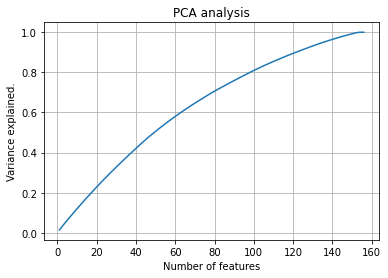

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


feature_names = X_train.columns.values.tolist()

pca = PCA(n_components=min(len(feature_names), len(X_train.index)))
pca.fit_transform(X)

fig, ax = plt.subplots()
var_explained = pca.explained_variance_ratio_.cumsum()
components = [i+1 for i in range(len(var_explained))]
ax.plot(components, var_explained)


ax.set(xlabel='Number of features', ylabel='Variance explained.',
       title='PCA analysis')
ax.grid()

fig.savefig("pca_analysis.png")
plt.show()

### Variance explained by feature

/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


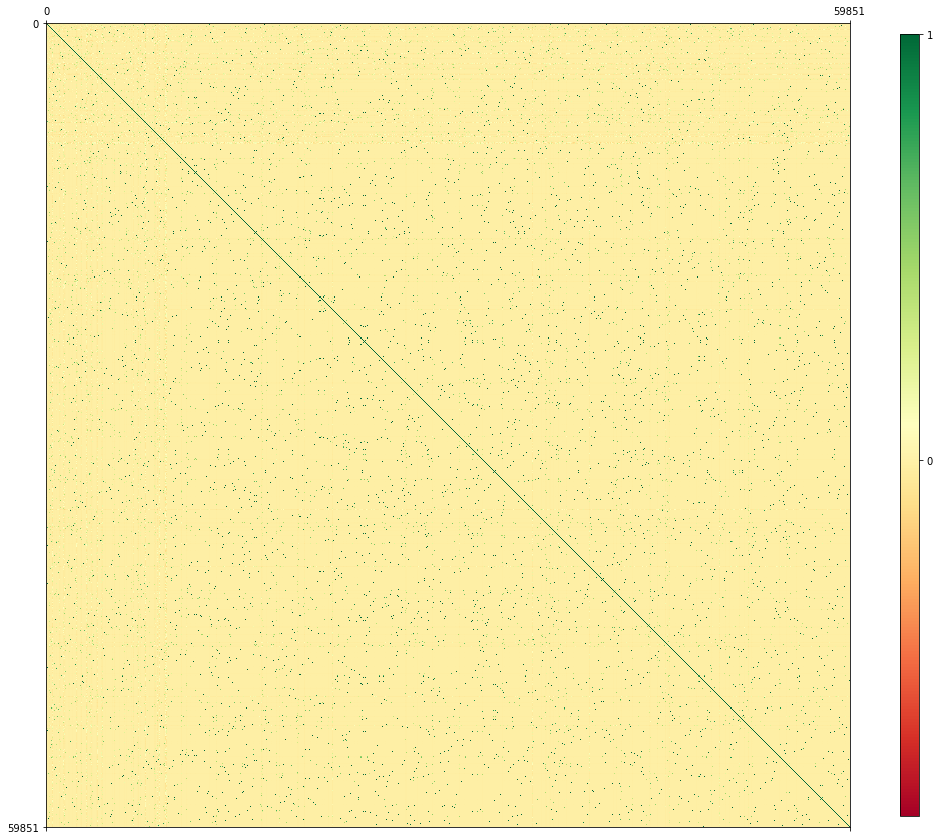

In [33]:
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy as sch

def plot_corr(df, size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    # Compute the correlation matrix for the received dataframe
    # Don't use df.corr() as it is is extremely slow
    corr = np.corrcoef(df.T)
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    ax.set_xticks([0, len(corr)])
    ax.set_yticks([0, len(corr)])
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

plot_corr(X_train, size=18)

### Agglomerative clustering

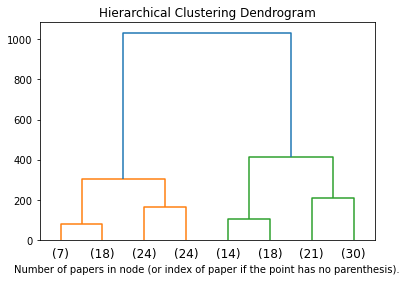

In [34]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


X = StandardScaler().fit_transform(X_train)
X = X_train

model = AgglomerativeClustering(distance_threshold = 0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=2)
plt.xlabel("Number of papers in node (or index of paper if the point has no parenthesis).")
plt.show()